# DCGAN (Deep Convolutional GAN)  
- pytorch로 구현  

### Packages and Modules

In [1]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Set GPU device

In [4]:
device = torch.device('cuda:0')
print(device)

cuda:0


### Load data and preprocessing

In [5]:
# data path
data_path = os.path.join('./shirt_data')

# data preprocessing
target_size = (64,64)
batch_size = 32

# image resize and scaling ([0~255] -> [0~1] -> [-1,1] for tanh activation function)
transform = transforms.Compose([transforms.Resize((target_size)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# apply transforms
data_folder = ImageFolder(data_path, 
                          transform=transform, 
                          target_transform=None)

# load data
data_loader = DataLoader(data_folder,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=4,
                         drop_last=True)

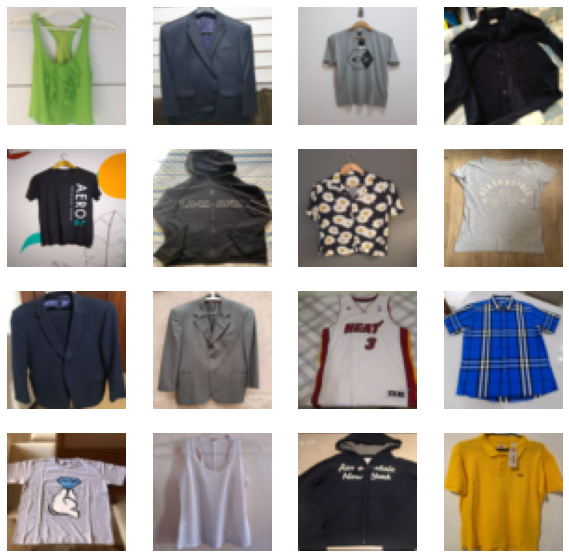

In [6]:
# show samples
def show_image(images):
    # transform array
    img = np.array(images)
    # [-1,1] -> [0,1] and (channels, width, height) -> (width, height, channels)
    plt.imshow(np.transpose((img+1)/2, (1,2,0)))
    plt.axis('off')
    
def show_samples(num, data_loader):
    for i, [image, _] in enumerate(data_loader):
        n = int(np.ceil(np.sqrt(num)))
        plt.figure(figsize=(10,10))
        for j in range(num):
            plt.subplot(n,n,j+1)
            show_image(image[j])
        plt.show()
        if i==0: 
            break
        
show_samples(16, data_loader)

### Define Models

In [7]:
# create generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # define generator model
        self.g_model = nn.Sequential(
            # input is batch_size x latent_dim x 1 x 1
            nn.ConvTranspose2d(100, 1024, kernel_size=4, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            # output size is batch_size x 1024 x 4 x 4
            
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # output size is batch_size x 512 x 8 x 8
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # output size is batch_size x 256 x 16 x 16
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # output size is batch_size x 128 x 32 x 32
            
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # output size is batch_size x 3 x 64 x 64
        )
    
    def forward(self, x):
        return self.g_model(x)

In [8]:
# create discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # define discrminator model
        self.d_model = nn.Sequential(
            # input size is 32x32x64
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input size is 16x16x128
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input size is 8x8x256
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input size is 4x4x512
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input size is 2x2x1024
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        out = self.d_model(x)
        return out.view(-1,1)

In [9]:
# load model with gpu device
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [10]:
# set hyperparameter
latent_dim = 100
lr = 0.0002
beta_1 = 0.5

# set loss function and optimizer
loss_func = nn.BCELoss().cuda()
gen_optim = optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, 0.999))
dis_optim = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, 0.999))

# create real and fake label
real_label = torch.ones(batch_size,1,device=device)
fake_label = torch.zeros(batch_size,1, device=device)

### Model training

In [11]:
# define function for showing generated images
def plot_generated_images(generated, epoch, every):
    # plot generated images in every n epoch
    if epoch%every==0:
        plt.figure(figsize=(12,8))
        for i in range(12):
            # [-1,1] -> [0,1] and (channels, width, height) -> (width, height, channels)
            img = generated[i].detach().cpu().numpy()
            img = np.transpose((img+1)/2, (1,2,0))
            plt.subplot(3,4,i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()
    else: 
        pass

In [12]:
# define function for model training
def train_gan(g_model, d_model, batch_size, latent_dim, n_epochs, show_image_epoch):
    # create losses list
    d_loss, g_loss = [], []
    # get start time
    start_time = time.time()
    # n_epochs 만큼 훈련 진행
    for epoch in tqdm(range(n_epochs)):
        # get start time of each epoch
        initial_epoch_time = time.time()
        # train every batch
        for _, [X_batch, __] in enumerate(data_loader):
            """ train discriminator model """
            dis_optim.zero_grad()
            # step1: 노이즈 생성
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            # step2: 생성자를 통해 가짜 이미지 생성한 후 판별자에 입력
            X_fake = g_model.forward(noise)
            y_fake = d_model.forward(X_fake)
            # step3: 진짜 이미지를 판별자에 입력
            X_real = X_batch.to(device)
            y_real = d_model.forward(X_real)
            # step4: step2와 step3에서 얻은 라벨들을 가지고 로스 계산
            real_loss = torch.sum(loss_func(y_fake, fake_label))
            fake_loss = torch.sum(loss_func(y_real, real_label))
            dis_loss = (real_loss+fake_loss)/2
            # step5: 로스와 옵티마이저 업데이트
            dis_loss.backward()
            dis_optim.step()
            
            """ train generator model """
            gen_optim.zero_grad()
            # step1: 생성자를 통해 가짜 이미지 생성한 후 판별자에 입력
            gen_fake = g_model.forward(noise)
            dis_fake = d_model.forward(gen_fake)
            # step2: 생성한 가짜 이미지가 진짜라고 믿도록 판별자를 속이기
            gen_loss = torch.sum(loss_func(dis_fake, real_label))
            # step3: 로스와 옵티마이저 업데이트
            gen_loss.backward()
            gen_optim.step()
        # append loss in list
        dis_loss, gen_loss = dis_loss.detach().cpu().numpy(), gen_loss.detach().cpu().numpy()
        d_loss.append(dis_loss)
        g_loss.append(gen_loss)
        # get end time of each epoch
        end_epoch_time = time.time()
        epoch_time = end_epoch_time-initial_epoch_time
        # print number of epoch and time and losses
        print(f'Epoch {epoch+1}/{n_epochs}, time: {epoch_time}s\nDiscriminator loss is {dis_loss}, Generator loss is {gen_loss}')
        print('----------------------------------------------------------------------------------')
        # plot generated images
        plot_generated_images(gen_fake, epoch+1, show_image_epoch)
    end_time = time.time()
    print(f'Total time for training is {end_time-start_time}s')
    return gen_fake, d_loss, g_loss

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, time: 22.76731824874878s
Discriminator loss is 0.15382012724876404, Generator loss is 8.081475257873535
----------------------------------------------------------------------------------
Epoch 2/100, time: 18.860201358795166s
Discriminator loss is 0.31159815192222595, Generator loss is 3.74332332611084
----------------------------------------------------------------------------------
Epoch 3/100, time: 19.31195569038391s
Discriminator loss is 0.3803473711013794, Generator loss is 2.0782556533813477
----------------------------------------------------------------------------------
Epoch 4/100, time: 18.95670247077942s
Discriminator loss is 0.34749460220336914, Generator loss is 2.6155967712402344
----------------------------------------------------------------------------------
Epoch 5/100, time: 19.20603322982788s
Discriminator loss is 0.24442793428897858, Generator loss is 2.569091558456421
----------------------------------------------------------------------------------

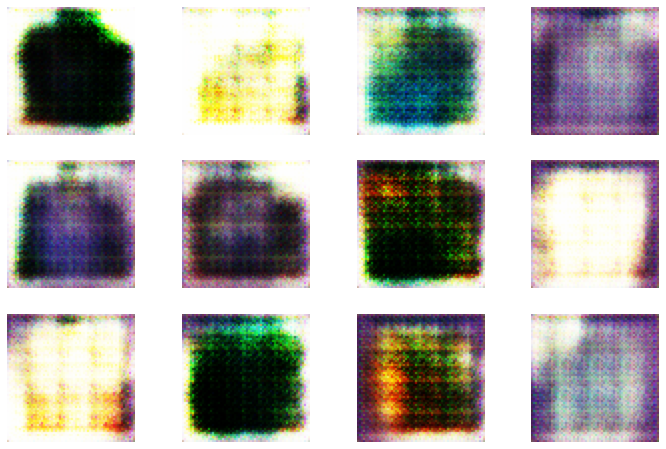

Epoch 6/100, time: 18.993361473083496s
Discriminator loss is 0.33427006006240845, Generator loss is 2.7562241554260254
----------------------------------------------------------------------------------
Epoch 7/100, time: 18.97626829147339s
Discriminator loss is 0.6228470802307129, Generator loss is 2.2156193256378174
----------------------------------------------------------------------------------
Epoch 8/100, time: 18.84909200668335s
Discriminator loss is 0.280524343252182, Generator loss is 3.173506259918213
----------------------------------------------------------------------------------
Epoch 9/100, time: 18.930614709854126s
Discriminator loss is 0.28460878133773804, Generator loss is 2.2730419635772705
----------------------------------------------------------------------------------
Epoch 10/100, time: 19.107861042022705s
Discriminator loss is 0.5837773680686951, Generator loss is 2.1447579860687256
-------------------------------------------------------------------------------

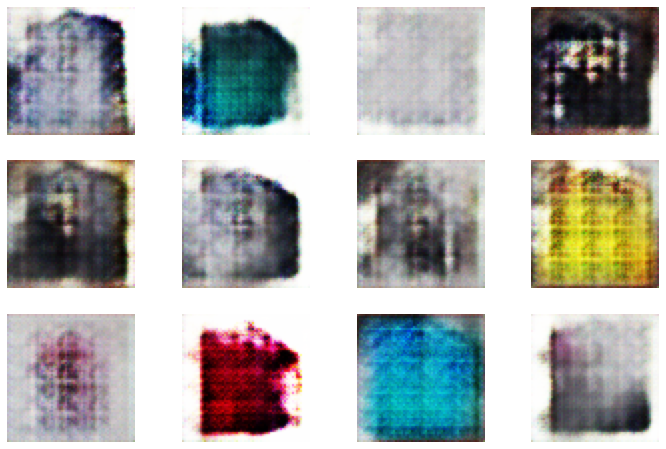

Epoch 11/100, time: 18.811145782470703s
Discriminator loss is 0.1357949823141098, Generator loss is 3.8751394748687744
----------------------------------------------------------------------------------
Epoch 12/100, time: 19.642346620559692s
Discriminator loss is 0.45191726088523865, Generator loss is 6.1944780349731445
----------------------------------------------------------------------------------
Epoch 13/100, time: 19.6247775554657s
Discriminator loss is 0.9186786413192749, Generator loss is 7.7407145500183105
----------------------------------------------------------------------------------
Epoch 14/100, time: 19.550376415252686s
Discriminator loss is 0.2819530963897705, Generator loss is 3.761134624481201
----------------------------------------------------------------------------------
Epoch 15/100, time: 19.369821548461914s
Discriminator loss is 0.3916003406047821, Generator loss is 3.5691564083099365
---------------------------------------------------------------------------

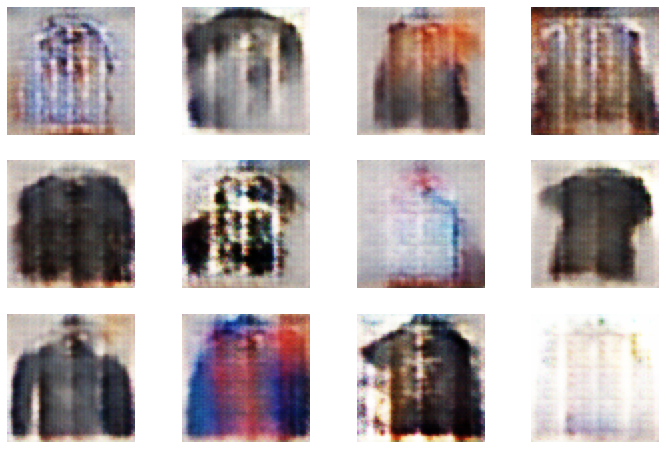

Epoch 16/100, time: 19.32085108757019s
Discriminator loss is 0.821907103061676, Generator loss is 0.7525074481964111
----------------------------------------------------------------------------------
Epoch 17/100, time: 19.24333119392395s
Discriminator loss is 0.3803326487541199, Generator loss is 5.509312152862549
----------------------------------------------------------------------------------
Epoch 18/100, time: 19.0269193649292s
Discriminator loss is 0.10387183725833893, Generator loss is 3.7889883518218994
----------------------------------------------------------------------------------
Epoch 19/100, time: 19.15401601791382s
Discriminator loss is 0.4162262976169586, Generator loss is 6.351983070373535
----------------------------------------------------------------------------------
Epoch 20/100, time: 19.40919852256775s
Discriminator loss is 0.22037959098815918, Generator loss is 3.916597366333008
---------------------------------------------------------------------------------

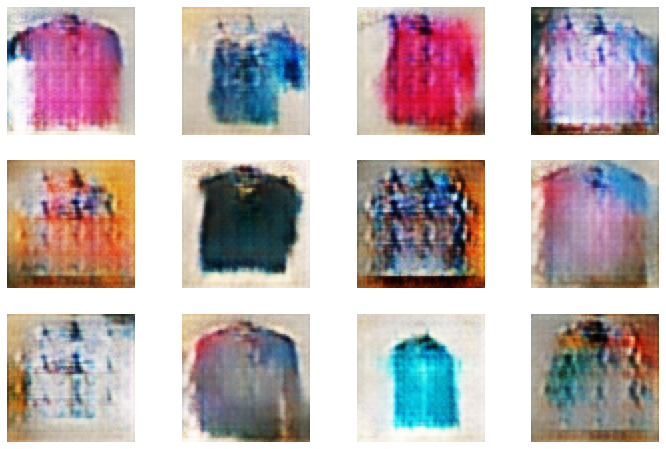

Epoch 21/100, time: 19.44492483139038s
Discriminator loss is 0.17329999804496765, Generator loss is 2.2959675788879395
----------------------------------------------------------------------------------
Epoch 22/100, time: 19.065861463546753s
Discriminator loss is 0.16649365425109863, Generator loss is 5.651379585266113
----------------------------------------------------------------------------------
Epoch 23/100, time: 18.93003559112549s
Discriminator loss is 0.34454113245010376, Generator loss is 6.051383972167969
----------------------------------------------------------------------------------
Epoch 24/100, time: 18.907768726348877s
Discriminator loss is 0.23765361309051514, Generator loss is 2.800224542617798
----------------------------------------------------------------------------------
Epoch 25/100, time: 18.77963423728943s
Discriminator loss is 0.15772166848182678, Generator loss is 4.5484819412231445
--------------------------------------------------------------------------

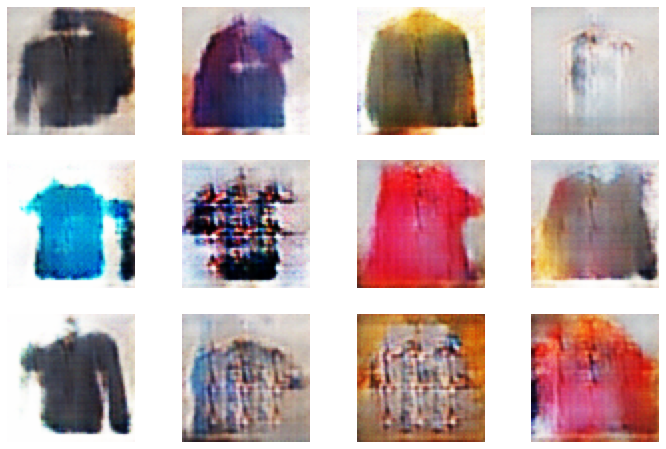

Epoch 26/100, time: 18.74569034576416s
Discriminator loss is 0.32438814640045166, Generator loss is 2.967331647872925
----------------------------------------------------------------------------------
Epoch 27/100, time: 18.850423574447632s
Discriminator loss is 0.1657852679491043, Generator loss is 3.496515989303589
----------------------------------------------------------------------------------
Epoch 28/100, time: 18.739842176437378s
Discriminator loss is 0.16174821555614471, Generator loss is 1.8862028121948242
----------------------------------------------------------------------------------
Epoch 29/100, time: 18.837783336639404s
Discriminator loss is 0.1396295577287674, Generator loss is 5.240631103515625
----------------------------------------------------------------------------------
Epoch 30/100, time: 18.916553497314453s
Discriminator loss is 0.4930158853530884, Generator loss is 9.892516136169434
----------------------------------------------------------------------------

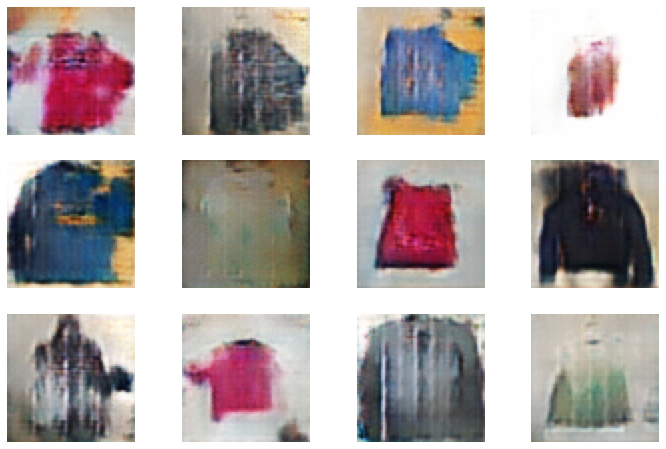

Epoch 31/100, time: 18.934332609176636s
Discriminator loss is 0.07114126533269882, Generator loss is 3.874398708343506
----------------------------------------------------------------------------------
Epoch 32/100, time: 18.959165334701538s
Discriminator loss is 0.22524459660053253, Generator loss is 3.916628122329712
----------------------------------------------------------------------------------
Epoch 33/100, time: 19.039896249771118s
Discriminator loss is 0.16069522500038147, Generator loss is 5.960310935974121
----------------------------------------------------------------------------------
Epoch 34/100, time: 18.9314546585083s
Discriminator loss is 0.06697335839271545, Generator loss is 3.5331802368164062
----------------------------------------------------------------------------------
Epoch 35/100, time: 18.903507471084595s
Discriminator loss is 0.23788000643253326, Generator loss is 2.792820453643799
--------------------------------------------------------------------------

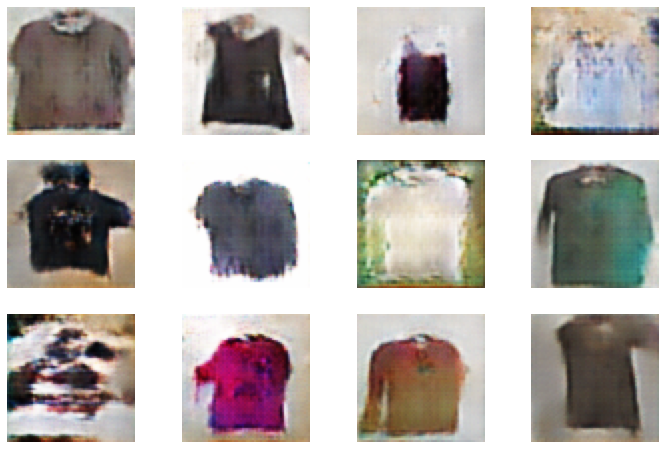

Epoch 36/100, time: 18.82192039489746s
Discriminator loss is 0.3048141300678253, Generator loss is 1.9749447107315063
----------------------------------------------------------------------------------
Epoch 37/100, time: 19.04262351989746s
Discriminator loss is 0.649385929107666, Generator loss is 13.161053657531738
----------------------------------------------------------------------------------
Epoch 38/100, time: 18.833673000335693s
Discriminator loss is 1.631060242652893, Generator loss is 2.924636125564575
----------------------------------------------------------------------------------
Epoch 39/100, time: 18.880621433258057s
Discriminator loss is 0.023112326860427856, Generator loss is 5.183006286621094
----------------------------------------------------------------------------------
Epoch 40/100, time: 18.930102586746216s
Discriminator loss is 0.5302002429962158, Generator loss is 1.9165575504302979
-----------------------------------------------------------------------------

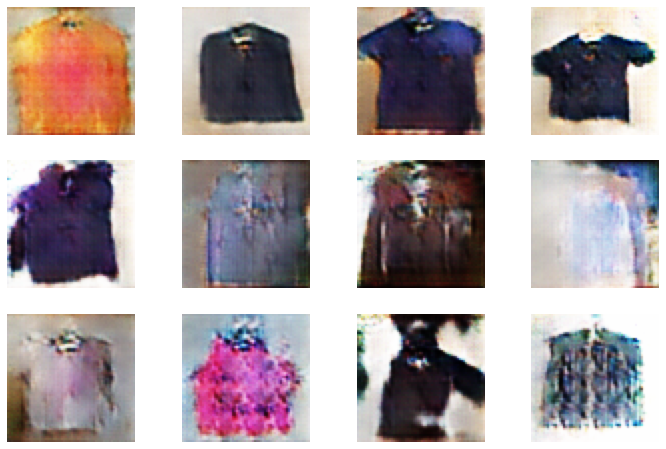

Epoch 41/100, time: 18.99230647087097s
Discriminator loss is 0.3531321585178375, Generator loss is 2.900106906890869
----------------------------------------------------------------------------------
Epoch 42/100, time: 18.96753764152527s
Discriminator loss is 0.22464606165885925, Generator loss is 6.430988311767578
----------------------------------------------------------------------------------
Epoch 43/100, time: 18.887099027633667s
Discriminator loss is 0.09083549678325653, Generator loss is 3.856245994567871
----------------------------------------------------------------------------------
Epoch 44/100, time: 19.07853937149048s
Discriminator loss is 0.1270962357521057, Generator loss is 5.429418563842773
----------------------------------------------------------------------------------
Epoch 45/100, time: 19.07954716682434s
Discriminator loss is 0.14409613609313965, Generator loss is 1.8942592144012451
------------------------------------------------------------------------------

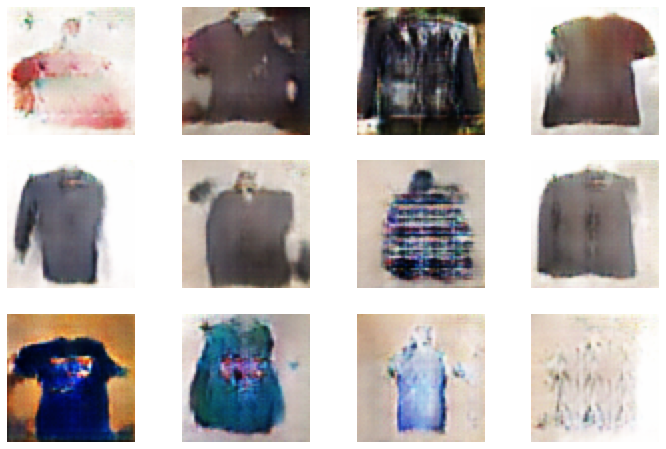

Epoch 46/100, time: 19.139111518859863s
Discriminator loss is 0.24865734577178955, Generator loss is 5.832234859466553
----------------------------------------------------------------------------------
Epoch 47/100, time: 19.104840755462646s
Discriminator loss is 0.2360536754131317, Generator loss is 5.718167781829834
----------------------------------------------------------------------------------
Epoch 48/100, time: 19.25297737121582s
Discriminator loss is 0.2884634733200073, Generator loss is 1.5384368896484375
----------------------------------------------------------------------------------
Epoch 49/100, time: 19.201029300689697s
Discriminator loss is 0.1978444755077362, Generator loss is 6.377547264099121
----------------------------------------------------------------------------------
Epoch 50/100, time: 18.972837924957275s
Discriminator loss is 0.09446340799331665, Generator loss is 4.767199993133545
----------------------------------------------------------------------------

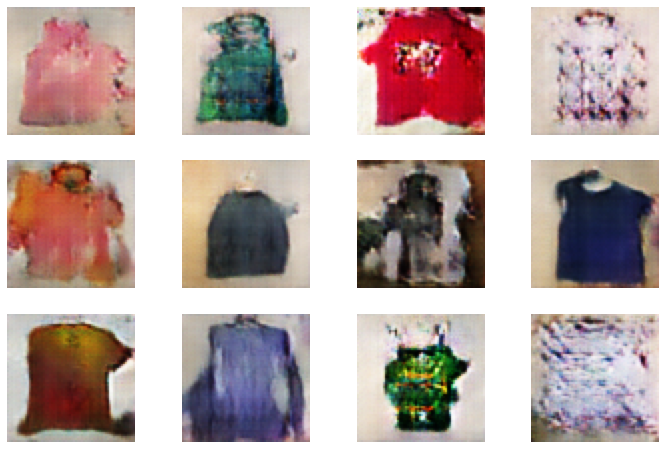

Epoch 51/100, time: 19.137983560562134s
Discriminator loss is 0.17665386199951172, Generator loss is 2.474036693572998
----------------------------------------------------------------------------------
Epoch 52/100, time: 19.103412866592407s
Discriminator loss is 0.6509759426116943, Generator loss is 13.347532272338867
----------------------------------------------------------------------------------
Epoch 53/100, time: 19.248737812042236s
Discriminator loss is 0.05861451476812363, Generator loss is 6.767515182495117
----------------------------------------------------------------------------------
Epoch 54/100, time: 19.20708966255188s
Discriminator loss is 0.0069047389551997185, Generator loss is 6.527652740478516
----------------------------------------------------------------------------------
Epoch 55/100, time: 19.850014686584473s
Discriminator loss is 0.4584186375141144, Generator loss is 7.110172271728516
-------------------------------------------------------------------------

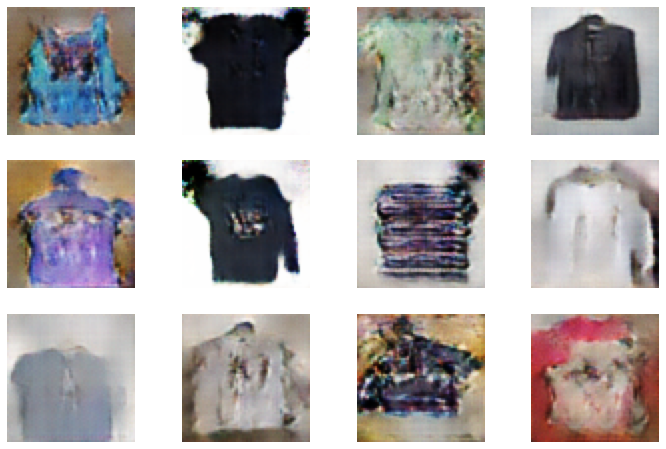

Epoch 56/100, time: 19.506502866744995s
Discriminator loss is 0.16625644266605377, Generator loss is 3.3251137733459473
----------------------------------------------------------------------------------
Epoch 57/100, time: 19.763649940490723s
Discriminator loss is 0.1132887452840805, Generator loss is 4.10050630569458
----------------------------------------------------------------------------------
Epoch 58/100, time: 19.455050468444824s
Discriminator loss is 0.11680883169174194, Generator loss is 4.57200288772583
----------------------------------------------------------------------------------
Epoch 59/100, time: 19.035189867019653s
Discriminator loss is 0.1538742035627365, Generator loss is 8.605157852172852
----------------------------------------------------------------------------------
Epoch 60/100, time: 19.088040113449097s
Discriminator loss is 0.09498833119869232, Generator loss is 5.957735538482666
----------------------------------------------------------------------------

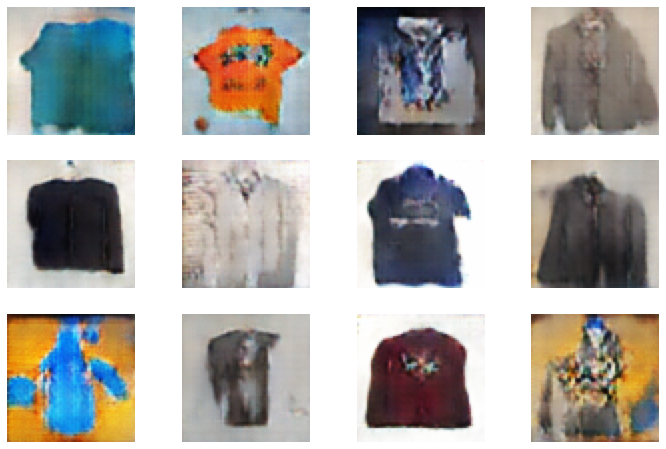

Epoch 61/100, time: 19.19828748703003s
Discriminator loss is 0.2059725821018219, Generator loss is 6.797800064086914
----------------------------------------------------------------------------------
Epoch 62/100, time: 18.99395489692688s
Discriminator loss is 0.5397161841392517, Generator loss is 4.031825065612793
----------------------------------------------------------------------------------
Epoch 63/100, time: 18.99009871482849s
Discriminator loss is 0.14603298902511597, Generator loss is 7.426368236541748
----------------------------------------------------------------------------------
Epoch 64/100, time: 19.56067180633545s
Discriminator loss is 0.03141424059867859, Generator loss is 5.203896522521973
----------------------------------------------------------------------------------
Epoch 65/100, time: 19.473894357681274s
Discriminator loss is 0.4127773344516754, Generator loss is 9.99359130859375
---------------------------------------------------------------------------------

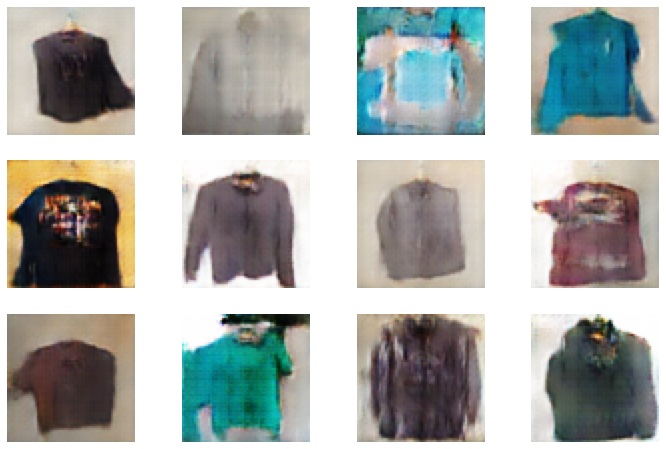

Epoch 66/100, time: 19.120168209075928s
Discriminator loss is 0.0796375498175621, Generator loss is 4.694096565246582
----------------------------------------------------------------------------------
Epoch 67/100, time: 19.21265459060669s
Discriminator loss is 0.03904486447572708, Generator loss is 8.884984970092773
----------------------------------------------------------------------------------
Epoch 68/100, time: 19.167428970336914s
Discriminator loss is 0.3313937485218048, Generator loss is 1.4570109844207764
----------------------------------------------------------------------------------
Epoch 69/100, time: 18.82944393157959s
Discriminator loss is 0.020493393763899803, Generator loss is 4.8048295974731445
----------------------------------------------------------------------------------
Epoch 70/100, time: 19.289807081222534s
Discriminator loss is 0.06370614469051361, Generator loss is 5.592350482940674
--------------------------------------------------------------------------

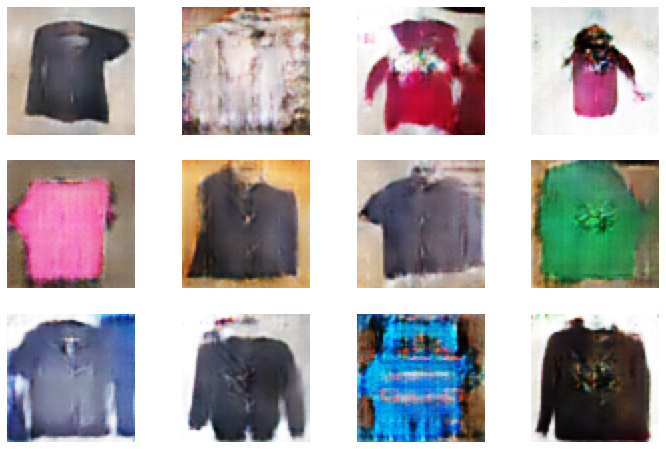

Epoch 71/100, time: 19.23806405067444s
Discriminator loss is 0.3914252817630768, Generator loss is 8.061576843261719
----------------------------------------------------------------------------------
Epoch 72/100, time: 19.204695463180542s
Discriminator loss is 0.01400509849190712, Generator loss is 5.936716556549072
----------------------------------------------------------------------------------
Epoch 73/100, time: 19.363046646118164s
Discriminator loss is 0.10183976590633392, Generator loss is 6.902127265930176
----------------------------------------------------------------------------------
Epoch 74/100, time: 19.039066791534424s
Discriminator loss is 0.10613846033811569, Generator loss is 4.088426113128662
----------------------------------------------------------------------------------
Epoch 75/100, time: 19.318468809127808s
Discriminator loss is 0.2965593934059143, Generator loss is 6.7522430419921875
---------------------------------------------------------------------------

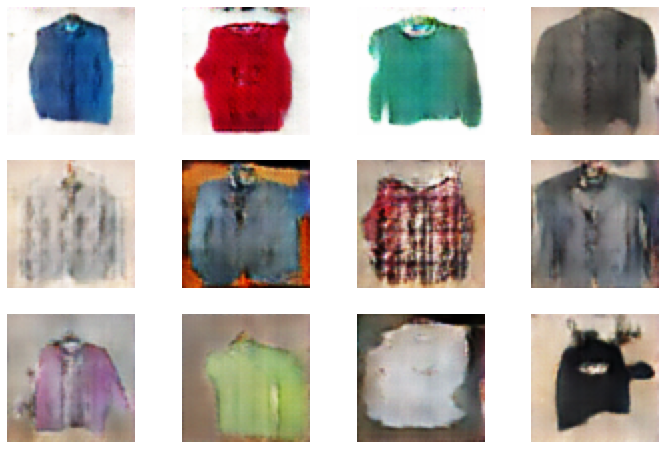

Epoch 76/100, time: 19.35115361213684s
Discriminator loss is 0.02641208842396736, Generator loss is 5.959003448486328
----------------------------------------------------------------------------------
Epoch 77/100, time: 19.258870840072632s
Discriminator loss is 0.09921669960021973, Generator loss is 5.7661542892456055
----------------------------------------------------------------------------------
Epoch 78/100, time: 19.31515669822693s
Discriminator loss is 0.03673970326781273, Generator loss is 6.584208011627197
----------------------------------------------------------------------------------
Epoch 79/100, time: 19.18057608604431s
Discriminator loss is 0.03179893642663956, Generator loss is 4.996335506439209
----------------------------------------------------------------------------------
Epoch 80/100, time: 19.123965978622437s
Discriminator loss is 0.10611104220151901, Generator loss is 7.915707588195801
---------------------------------------------------------------------------

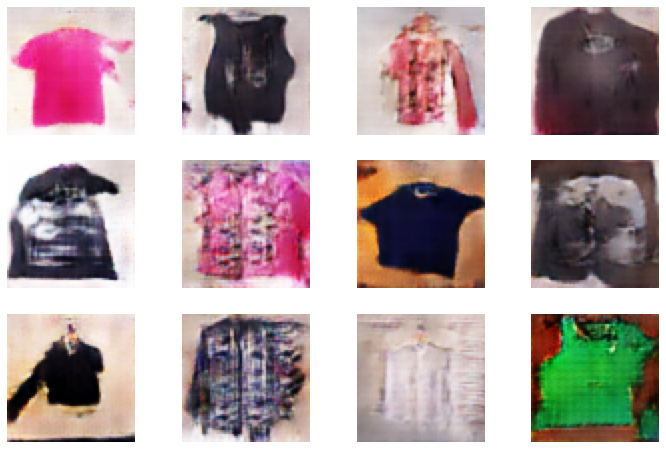

Epoch 81/100, time: 18.959858179092407s
Discriminator loss is 0.0863637924194336, Generator loss is 4.584141731262207
----------------------------------------------------------------------------------
Epoch 82/100, time: 19.05335283279419s
Discriminator loss is 0.4810267388820648, Generator loss is 1.1066762208938599
----------------------------------------------------------------------------------
Epoch 83/100, time: 19.306931257247925s
Discriminator loss is 0.012265707366168499, Generator loss is 7.310553550720215
----------------------------------------------------------------------------------
Epoch 84/100, time: 19.78563666343689s
Discriminator loss is 0.035184476524591446, Generator loss is 5.723686218261719
----------------------------------------------------------------------------------
Epoch 85/100, time: 19.011399507522583s
Discriminator loss is 0.10790833830833435, Generator loss is 7.140036582946777
--------------------------------------------------------------------------

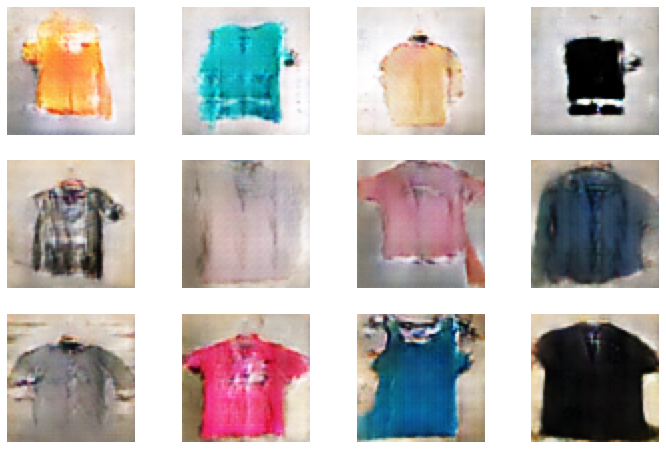

Epoch 86/100, time: 19.235243320465088s
Discriminator loss is 0.07496224343776703, Generator loss is 5.391515731811523
----------------------------------------------------------------------------------
Epoch 87/100, time: 19.14853000640869s
Discriminator loss is 0.1889050453901291, Generator loss is 5.076698303222656
----------------------------------------------------------------------------------
Epoch 88/100, time: 19.205196380615234s
Discriminator loss is 0.30027449131011963, Generator loss is 2.438331127166748
----------------------------------------------------------------------------------
Epoch 89/100, time: 19.147698879241943s
Discriminator loss is 0.061932045966386795, Generator loss is 7.076395511627197
----------------------------------------------------------------------------------
Epoch 90/100, time: 19.073662281036377s
Discriminator loss is 0.045142486691474915, Generator loss is 5.611393928527832
-------------------------------------------------------------------------

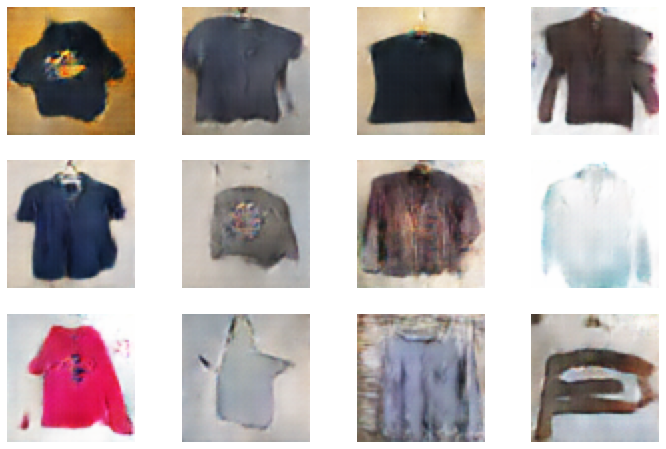

Epoch 91/100, time: 19.296653032302856s
Discriminator loss is 0.015477187931537628, Generator loss is 6.751928329467773
----------------------------------------------------------------------------------
Epoch 92/100, time: 19.397903203964233s
Discriminator loss is 0.6006109714508057, Generator loss is 18.769092559814453
----------------------------------------------------------------------------------
Epoch 93/100, time: 19.25012755393982s
Discriminator loss is 0.121918685734272, Generator loss is 6.217795372009277
----------------------------------------------------------------------------------
Epoch 94/100, time: 18.908904790878296s
Discriminator loss is 0.036432139575481415, Generator loss is 5.865220069885254
----------------------------------------------------------------------------------
Epoch 95/100, time: 19.518344163894653s
Discriminator loss is 0.38143646717071533, Generator loss is 9.32736873626709
---------------------------------------------------------------------------

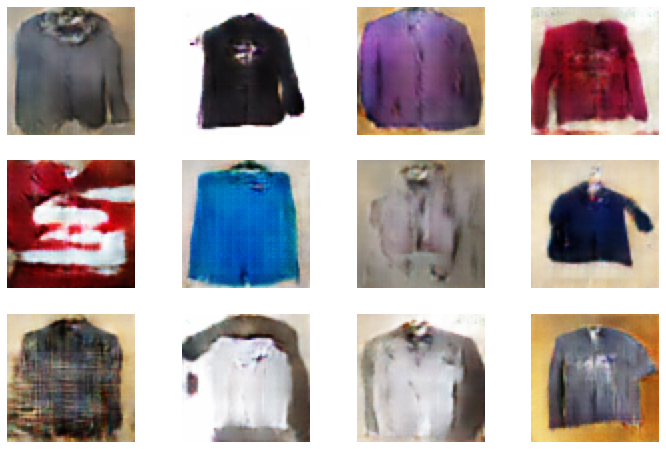

Epoch 96/100, time: 19.100661039352417s
Discriminator loss is 0.03333227336406708, Generator loss is 5.807887077331543
----------------------------------------------------------------------------------
Epoch 97/100, time: 19.05465865135193s
Discriminator loss is 0.058073580265045166, Generator loss is 4.5593719482421875
----------------------------------------------------------------------------------
Epoch 98/100, time: 19.494760513305664s
Discriminator loss is 0.030613012611865997, Generator loss is 7.420168876647949
----------------------------------------------------------------------------------
Epoch 99/100, time: 19.48877739906311s
Discriminator loss is 0.025891108438372612, Generator loss is 6.287524700164795
----------------------------------------------------------------------------------
Epoch 100/100, time: 19.218570232391357s
Discriminator loss is 0.00807739794254303, Generator loss is 6.814191818237305
----------------------------------------------------------------------

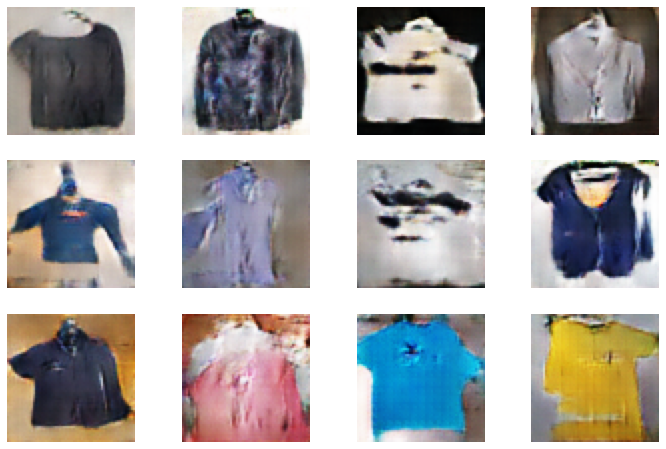

Total time for training is 1924.7103779315948s


In [13]:
# model training
EPOCH = 100

generated_images = train_gan(g_model=generator,
                             d_model=discriminator,
                             batch_size=batch_size,
                             latent_dim=latent_dim,
                             n_epochs=EPOCH,
                             show_image_epoch=5) 

In [14]:
# get generated image set and losses
generated, dis_losses, gen_losses = generated_images

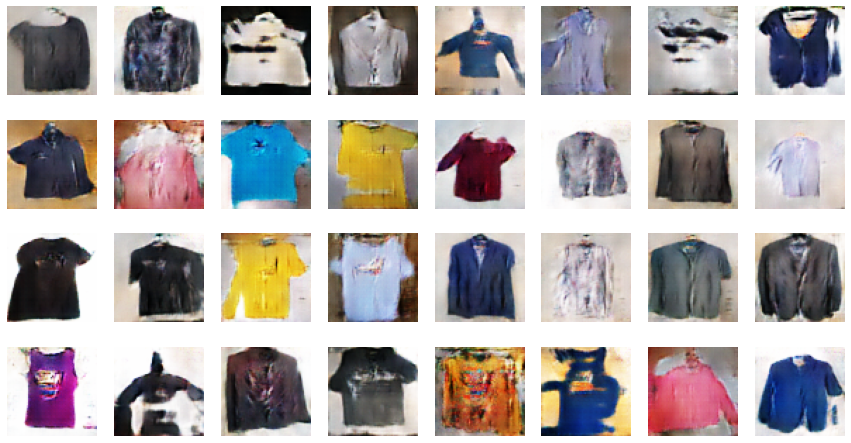

In [15]:
# show result of GAN
plt.figure(figsize=(15,8))
for i in range(32):
    img = generated[i].detach().cpu().numpy()
    plt.subplot(4,8,i+1)
    img = np.transpose((img+1)/2, (1,2,0))
    plt.imshow(img)
    plt.axis('off')
plt.show()

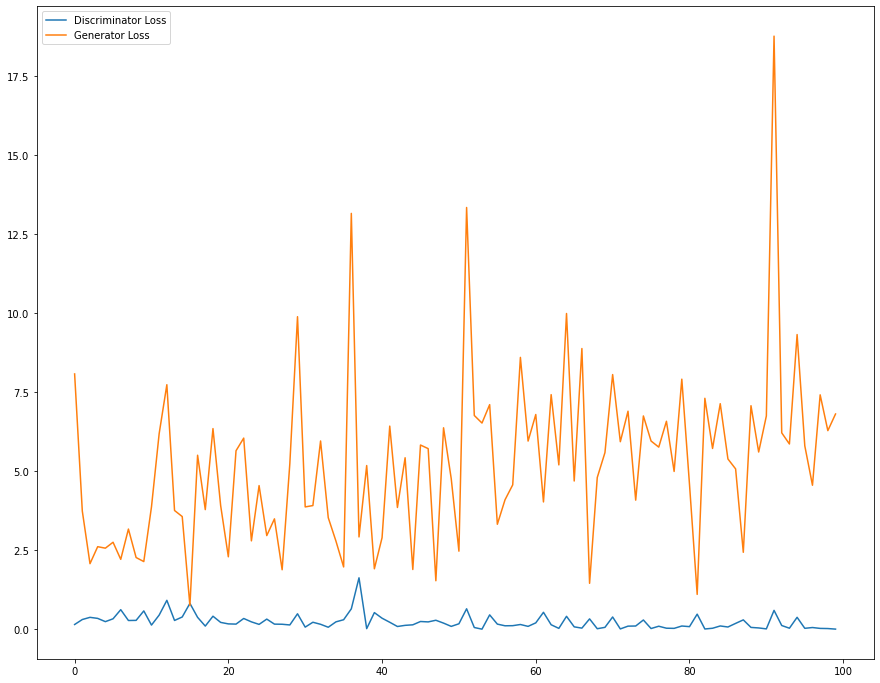

In [16]:
plt.figure(figsize=(15,12))
plt.plot(np.arange(len(dis_losses)), dis_losses, label='Discriminator Loss')
plt.plot(np.arange(len(gen_losses)), gen_losses, label='Generator Loss')
plt.legend(loc='upper left')
plt.show()